# 13. DDPG Algorithm

## 13.1. Intro

Deep Deterministic Policy Gradient, DDPG: 深度确定性策略梯度

## 13.2. DDPG Algorithm

$\nabla_\theta J(\pi_\theta) = \mathbb{E}_{s \sim v^{\pi_\beta}}[\nabla_\theta \mu_\theta(s)\nabla_a Q_\omega^\mu(s, a)|_{a = \mu_\theta(s)}]$

$\omega^- \leftarrow \tau \omega + (1 - \tau)\omega^-$

算法：
伪代码 DDPG：
1. 随机噪声可以用$\mathcal{N}$, 随机初始化网络参数$\omega, \theta$分别初始化Critic和Actor网络$Q_\omega(s, a)$和$\mu_\theta(s)$
2. 复制相同参数$\omega^- \leftarrow \omega$和$\theta^- \leftarrow \theta$, 初始化目标网络$Q_{\omega^-}, \mu_{\theta^-}$
3. **for**  $e = 1 \rightarrow E$ **do**:
   1. 初始化随机过程$\mathcal{N}$用于动作探索
   2. 获取环境初始状态$s_1$
   3. **for** $t = 1 \rightarrow T$ **do**:
      1. 根据当前策略和噪声选择动作$a_t = \mu_\theta(s_t) + \mathcal{N}$ 
      2. 执行动作$a_t$, 获取$r_t$, 状态变为$s_{t+1}$
      3. 将$(s_t, a_t, r_t, s_{t+1})$存回池$R$
      4. 从$R$中采样$N$个元组$\{(s_i, a_i, r_i, s_{i + 1})\}_{i = 1, ......, N}$
      5. 对每个元组，用目标网络，计算$y_i = r_i + \gamma Q_{\omega^-}(s_{i + 1}, \mu_{\theta^-}(s_{i+1}))$
      6. 最小化目标损失$L = \frac1N\sum_{i=1}^N(y_i - Q_\omega(s_i, a_i))^2$, 以此更新当前Critic网络
      7. 计算采样的策略梯度，以此更新当前Actor网络：$\nabla_\theta J \approx \frac1N\sum_{i=1}^N\nabla_\theta\mu_\theta(s_i)\nabla_aQ_\omega(s_i, a) |_{a = \mu_\theta(s_i)}$
      8. 更新目标网络 $\omega^- \leftarrow \tau\omega + (1 - \tau)\omega^-\theta^- \leftarrow \tau \theta + (1 - \tau)\theta^-$
   4. **end for**
4. **end for**

## 13.3. DDPG Implementation

In [5]:
import random
import gym
import numpy as np
if not hasattr(np, "bool8"):
  np.bool8 = np.bool_ # 这样写np不用降级
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [6]:
class PolicyNet(torch.nn.Module):
  """一层隐藏层的Q网络"""
  def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
    super(PolicyNet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
    self.action_bound = action_bound # 可接受的动作最大值
    
  def forward(self, x):
    x = F.relu(self.fc1(x)) 
    return torch.tanh(self.fc2(x)) * self.action_bound
  
class QValueNet(torch.nn.Module):
  """一层隐藏层的Q网络"""
  def __init__(self, state_dim, hidden_dim, action_dim):
    super(QValueNet, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
    self.fc_out = torch.nn.Linear(hidden_dim, 1)
    
  def forward(self, x, a):
    cat = torch.cat([x, a], dim=1) # 拼接状态和动作
    x = F.relu(self.fc1(cat))
    x = F.relu(self.fc2(x))
    return self.fc_out(x)

$\Delta x_t = \theta(\mu - x_{t - 1}) + \sigma W$

In [7]:
class DDPG:
  '''DDPG 算法'''
  def __init__(self, state_dim, hidden_dim, action_dim, 
              action_bound, sigma, actor_lr, critic_lr,
              tau, gamma, device):
    self.actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
    self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
    self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim, action_bound).to(device)
    self.target_critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
    # 初始化目标价值网络并设置和价值网络相同的参数
    self.target_critic.load_state_dict(self.critic.state_dict())
    # 初始化目标策略网络并设置和策略相同的参数
    self.target_actor.load_state_dict(self.actor.state_dict())
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
    self.gamma = gamma
    self.sigma = sigma # 高斯噪声的标准差，均值直接设为0
    self.tau = tau
    self.action_dim = action_dim
    self.device = device
    
  def take_action(self, state):
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    action = self.actor(state).item()
    # 给动作增加噪声，增加探索
    action = action + self.sigma * np.random.randn(self.action_dim)
    return action
  
  def soft_update(self, net, target_net):
    for param_target, param in zip(target_net.parameters(), net.parameters()):
      param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)
      
  def update(self, transition_dict):
    states = torch.tensor(transition_dict['states'], 
                          dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions'], 
                            dtype=torch.float).view(-1, 1).to(self.device)
    rewards = torch.tensor(transition_dict['rewards'],
                            dtype=torch.float).view(-1, 1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'],
                                dtype = torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'],
                          dtype=torch.float).view(-1, 1).to(self.device)
      
    next_q_values = self.target_critic(next_states, self.target_actor(next_states))
    q_targets = rewards + self.gamma * next_q_values * (1 - dones)
    critic_loss = torch.mean(F.mse_loss(self.critic(states, actions), q_targets))
    self.critic_optimizer.zero_grad()
    critic_loss.backward()
    self.critic_optimizer.step()
    
    actor_loss = -torch.mean(self.critic(states, self.actor(states)))
    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    self.actor_optimizer.step()
    
    self.soft_update(self.actor, self.target_actor) # 软更新策略网络
    self.soft_update(self.critic, self.target_critic) # 软更新价值网络

In [8]:
actor_lr = 3e-4
critic_lr = 3e-3
num_episodes = 200
hidden_dim = 64
gamma = 0.98
tau = 0.005 # 软更新参数
buffer_size = 10000
minimal_size = 1000
batch_size = 64
sigma = 0.01 # 高斯噪声标准差
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name ='Pendulum-v1'
env = gym.make(env_name)
np.random.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound,
            sigma, actor_lr, critic_lr, tau, gamma, device)

return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)



Iteration 9: 100%|██████████| 20/20 [00:21<00:00,  1.06s/it, episode=200, return=-184.085]


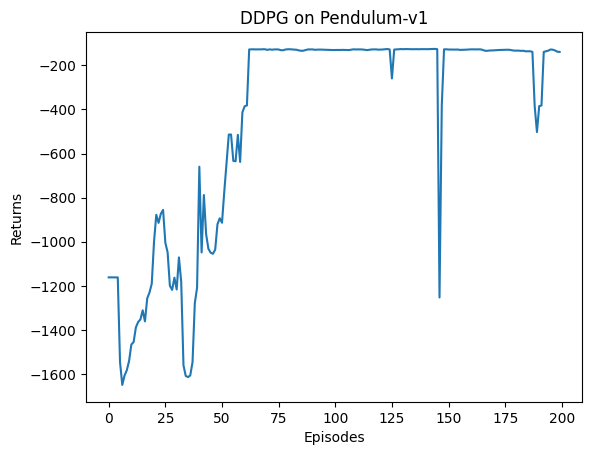

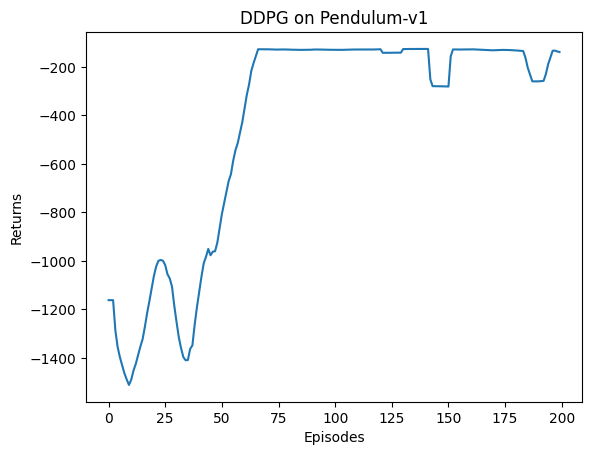

In [9]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG on {}'.format(env_name))
plt.show()
